In [2]:
import pandas as pd, numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
TARGET = 'SalePrice'

In [3]:
print(train.shape, test.shape)
print(train.isnull().sum().sort_values(ascending=False).head(10))
num_cols = train.select_dtypes(include=[np.number]).columns
cat_cols = train.select_dtypes(exclude=[np.number]).columns
print("수치형:", len(num_cols), "범주형:", len(cat_cols))

(1460, 81) (1459, 80)
PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageYrBlt      81
GarageCond       81
GarageType       81
dtype: int64
수치형: 38 범주형: 43


In [5]:
for col in num_cols:
    train[col].fillna(train[col].median(), inplace=True)
for col in cat_cols:
    train[col].fillna(train[col].mode()[0], inplace=True)

if TARGET in ['SalePrice', 'MedHouseVal']:
    train[TARGET] = np.log1p(train[TARGET])

/var/folders/fs/ldgbkzq52zng_83v61d49v5c0000gn/T/ipykernel_60827/1954693587.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].median(), inplace=True)
/var/folders/fs/ldgbkzq52zng_83v61d49v5c0000gn/T/ipykernel_60827/1954693587.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [6]:
for col in cat_cols:
    le = LabelEncoder()
    all_vals = pd.concat([train[col], test[col]], axis=0)
    le.fit(all_vals)
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

# ① 전체 면적 합산
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']
# ② 품질×면적 상호작용
train['QualArea'] = train['OverallQual'] * train['GrLivArea']
test['QualArea'] = test['OverallQual'] * test['GrLivArea']

In [7]:
X = train.drop(columns=[TARGET])
y = train[TARGET]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
params = {'objective':'regression','metric':'rmse','learning_rate':0.05,
          'num_leaves':31,'feature_fraction':0.8,'bagging_fraction':0.8,'seed':42}
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_valid, y_valid)
model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val],
                  num_boost_round=10000)
preds = model.predict(X_valid)
print("RMSE:", np.sqrt(mean_squared_error(y_valid, preds)))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3874
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Info] Start training from score 12.030658
RMSE: 0.14155855021052355


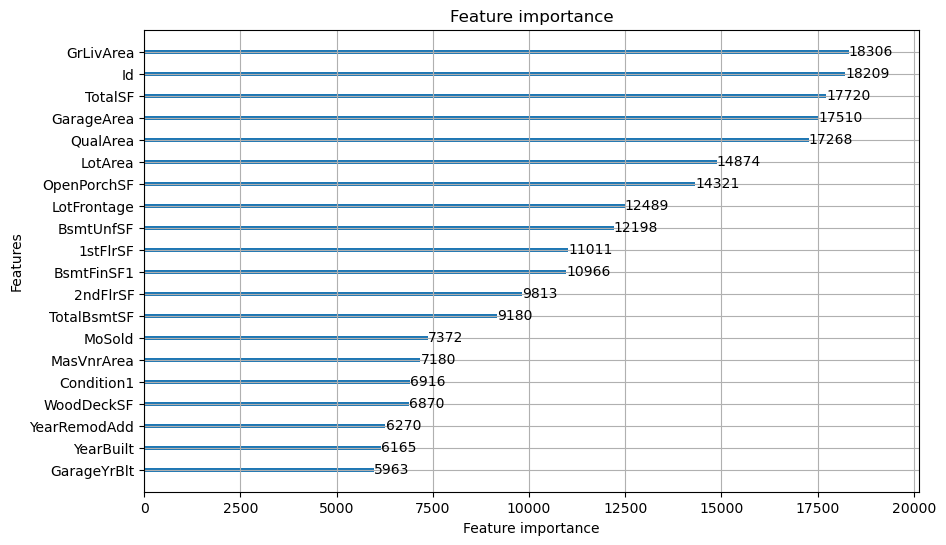

In [11]:
lgb.plot_importance(model, max_num_features=20, figsize=(10,6))
plt.show()

In [12]:
preds_test = model.predict(test)
if TARGET in ['SalePrice', 'MedHouseVal']:
    preds_test = np.expm1(preds_test)
submission = pd.DataFrame({'Id': test['Id'], TARGET: preds_test})
submission.to_csv('submission.csv', index=False)


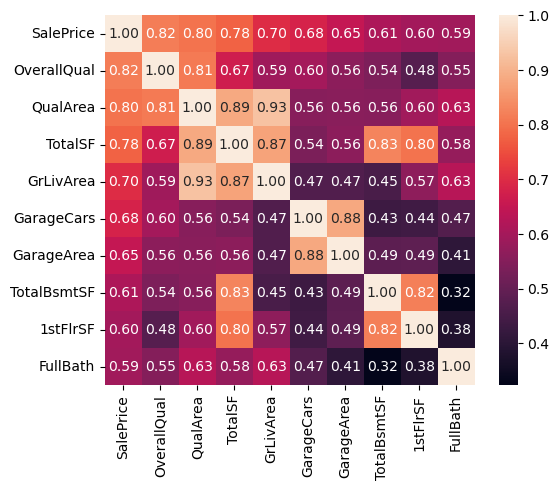

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt
num_cols = train.select_dtypes(include=['number']).columns
corr = train[num_cols].corr()
top_corr = corr[TARGET].sort_values(ascending=False).head(10)
cols = top_corr.index
corr_top = train[cols].corr()
sns.heatmap(corr_top, annot=True, fmt=".2f", square=True)
plt.show()

Text(0, 0.5, 'SalePrice')

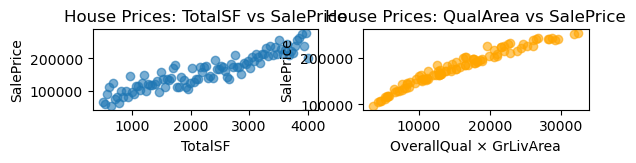

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.subplot(4, 2, 1)
total_sf = np.linspace(500, 4000, 100)
saleprice = 50000 + 50 * total_sf + np.random.normal(0, 20000, 100)
plt.scatter(total_sf, saleprice, alpha=0.6)
plt.title("House Prices: TotalSF vs SalePrice")
plt.xlabel("TotalSF"); plt.ylabel("SalePrice")

plt.subplot(4, 2, 2)
qual = np.random.randint(4, 10, 100)
area = np.random.uniform(800, 4000, 100)
plt.scatter(qual * area, 20000 + 40 * area + 10000 * qual, alpha=0.6, color='orange')
plt.title("House Prices: QualArea vs SalePrice")
plt.xlabel("OverallQual × GrLivArea"); plt.ylabel("SalePrice")